# Capstone Project - The Battle of Neighborhoods

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
%matplotlib inline

# 1. Acquire of Neighborhoods Data from Wikipedia

In [2]:
# Import the list of neighbourhoods in Toronto from "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M".
page = open('LPC.html', 'r', encoding='utf-8')
handle = page.read()
soup = BeautifulSoup(handle, 'lxml')
# Create a dataframe and remove the rows with a "Not assigned" value.
df = pd.read_html(str(soup.find_all('table')))[0]
df = df[df['Borough'] != 'Not assigned']
df = df[df['Neighbourhood'] != 'Not assigned']
df.shape

(210, 3)

In [3]:
# Create the coordinates of those neighborhoods, and merge the coordinates to the dataframe on "Postcode".
df_coordinates = pd.read_csv('Geo_Coordinates.csv')
df_coordinates.columns = ['Postcode', 'Latitude', 'Longitude']
df = df.merge(df_coordinates, on='Postcode')
# Due to the call limit from Foursquare, create the neighborhood dataframe only for the boroughes of Toronto.
df1 = df[df['Borough'].str.contains('Toronto')]
df1.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
12,M5B,Downtown Toronto,Ryerson,43.657162,-79.378937
13,M5B,Downtown Toronto,Garden District,43.657162,-79.378937
26,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418


# 2. Send Search Queries to Foursquare API

In [4]:
# Define Foursquare credentials and version
CLIENT_ID = 'Hidden' 
CLIENT_SECRET = 'Hidden'
VERSION = '20180605'

In [5]:
# Find all neighborhoods in Toronto and create the dataframe with restaurants, bakeries and Cafe's.
def getNearbyRestaurants(names, latitudes, longitudes, query='Restaurant',LIMIT=100, radius=500):   
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, query, radius, LIMIT)    
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    return(nearby_venues)
toronto_restaurants = getNearbyRestaurants(names=df1['Neighbourhood'], latitudes=df1['Latitude'], longitudes=df1['Longitude'])
toronto_restaurants.shape

Harbourfront
Regent Park
Ryerson
Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
The Danforth West
Riverdale
Design Exchange
Toronto Dominion Centre
Brockton
Exhibition Place
Parkdale Village
The Beaches West
India Bazaar
Commerce Court
Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North
Forest Hill West
High Park
The Junction South
North Toronto West
The Annex
North Midtown
Yorkville
Parkdale
Roncesvalles
Davisville
Harbord
University of Toronto
Runnymede
Swansea
Moore Park
Summerhill East
Chinatown
Grange Park
Kensington Market
Deer Park
Forest Hill SE
Rathnelly
South Hill
Summerhill West
CN Tower
Bathurst Quay
Island airport
Harbourfront West
King and Spadina
Railway Lands
South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown
St. James Town
First Canadian Place
Underground city


(2553, 7)

In [6]:
# Find all neighborhoods in Toronto and create the dataframe with supermarkets.
def getNearbySupermarkets(names, latitudes, longitudes, query='Supermarket',LIMIT=100, radius=500):   
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, query, radius, LIMIT)    
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    return(nearby_venues)
toronto_supermarkets = getNearbySupermarkets(names=df1['Neighbourhood'], latitudes=df1['Latitude'], longitudes=df1['Longitude'])
toronto_supermarkets.shape

Harbourfront
Regent Park
Ryerson
Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
The Danforth West
Riverdale
Design Exchange
Toronto Dominion Centre
Brockton
Exhibition Place
Parkdale Village
The Beaches West
India Bazaar
Commerce Court
Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North
Forest Hill West
High Park
The Junction South
North Toronto West
The Annex
North Midtown
Yorkville
Parkdale
Roncesvalles
Davisville
Harbord
University of Toronto
Runnymede
Swansea
Moore Park
Summerhill East
Chinatown
Grange Park
Kensington Market
Deer Park
Forest Hill SE
Rathnelly
South Hill
Summerhill West
CN Tower
Bathurst Quay
Island airport
Harbourfront West
King and Spadina
Railway Lands
South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown
St. James Town
First Canadian Place
Underground city


(66, 7)

In [7]:
# Remove the unreasonable categories.
toronto_supermarkets = toronto_supermarkets[toronto_supermarkets['Venue Category'] != 'Pharmacy']
toronto_supermarkets.shape

(63, 7)

In [8]:
# Find all neighborhoods in Toronto and create the dataframe with Ice-creams.
def getNearbyIcecreams(names, latitudes, longitudes, query='Ice cream',LIMIT=100, radius=500):   
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, query, radius, LIMIT)    
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    return(nearby_venues)
toronto_icecreams = getNearbyIcecreams(names=df1['Neighbourhood'], latitudes=df1['Latitude'], longitudes=df1['Longitude'])
toronto_icecreams.shape

Harbourfront
Regent Park
Ryerson
Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
The Danforth West
Riverdale
Design Exchange
Toronto Dominion Centre
Brockton
Exhibition Place
Parkdale Village
The Beaches West
India Bazaar
Commerce Court
Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North
Forest Hill West
High Park
The Junction South
North Toronto West
The Annex
North Midtown
Yorkville
Parkdale
Roncesvalles
Davisville
Harbord
University of Toronto
Runnymede
Swansea
Moore Park
Summerhill East
Chinatown
Grange Park
Kensington Market
Deer Park
Forest Hill SE
Rathnelly
South Hill
Summerhill West
CN Tower
Bathurst Quay
Island airport
Harbourfront West
King and Spadina
Railway Lands
South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown
St. James Town
First Canadian Place
Underground city


(274, 7)

In [9]:
# Combine all the above observations and remove duplicates.
df2 = toronto_supermarkets.append(toronto_restaurants).append(toronto_icecreams)
df2 = df2.drop_duplicates()
df2.shape

(2802, 7)

In [82]:
# According to the protocol, give the rate score from 1 to 5 to each venues based on the category.
df2['Category Rate'] = df2['Venue Category'].apply(lambda x: 5 if 'Supermarket' in x else 5 if 'Grocery' in x else 4 if 'Restaurant' in x else 3 if 'Spot' in x else 3 if 'Court' in x else 3 if 'Place' in x else 3 if 'ouse' in x else 3 if 'Pub' in x else 3 if 'Joint' in x else 3 if 'Diner' in x else 3 if 'Bistro' in x else 2 if 'Bakery' in x else 2 if "Ice" in x else 2 if 'Café' in x else 2 if 'Dessert' in x else 2 if 'Chocolate' in x else 2 if 'Donut' in x else 2 if 'Smoothie' in x else 2 if 'Coffee' in x else 2 if 'Deli' in x else 2 if 'Bagel' in x else 1)
df2.head(10)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category Rate
0,Ryerson,43.657162,-79.378937,Metro,43.658404,-79.376748,Supermarket,5
1,Garden District,43.657162,-79.378937,Metro,43.658404,-79.376748,Supermarket,5
2,St. James Town,43.651494,-79.375418,Metro,43.649027,-79.373313,Supermarket,5
4,Berczy Park,43.644771,-79.373306,Loblaws,43.644462,-79.369486,Supermarket,5
5,Berczy Park,43.644771,-79.373306,Metro,43.649027,-79.373313,Supermarket,5
7,Central Bay Street,43.657952,-79.387383,The Market by Longo's Elizabeth,43.655357,-79.385115,Supermarket,5
8,Central Bay Street,43.657952,-79.387383,Metro,43.660569,-79.383768,Supermarket,5
9,Christie,43.669542,-79.422564,Fiesta Farms,43.668471,-79.420485,Supermarket,5
10,Christie,43.669542,-79.422564,Loblaws,43.671807,-79.421102,Supermarket,5
11,Adelaide,43.650571,-79.384568,Rabba Marché,43.649216,-79.386908,Supermarket,5


In [84]:
# Save this dataframe
df2.to_csv('initialdf2.csv', encoding='utf-8', index=False)

# 3. Explore the Venues in the Neighborhoods of the City of Toronto

In [7]:
df3 = pd.read_csv('initialdf2.csv')
df3.head(10)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category Rate
0,Ryerson,43.657162,-79.378937,Metro,43.658404,-79.376748,Supermarket,5
1,Garden District,43.657162,-79.378937,Metro,43.658404,-79.376748,Supermarket,5
2,St. James Town,43.651494,-79.375418,Metro,43.649027,-79.373313,Supermarket,5
3,Berczy Park,43.644771,-79.373306,Loblaws,43.644462,-79.369486,Supermarket,5
4,Berczy Park,43.644771,-79.373306,Metro,43.649027,-79.373313,Supermarket,5
5,Central Bay Street,43.657952,-79.387383,The Market by Longo's Elizabeth,43.655357,-79.385115,Supermarket,5
6,Central Bay Street,43.657952,-79.387383,Metro,43.660569,-79.383768,Supermarket,5
7,Christie,43.669542,-79.422564,Fiesta Farms,43.668471,-79.420485,Supermarket,5
8,Christie,43.669542,-79.422564,Loblaws,43.671807,-79.421102,Supermarket,5
9,Adelaide,43.650571,-79.384568,Rabba Marché,43.649216,-79.386908,Supermarket,5


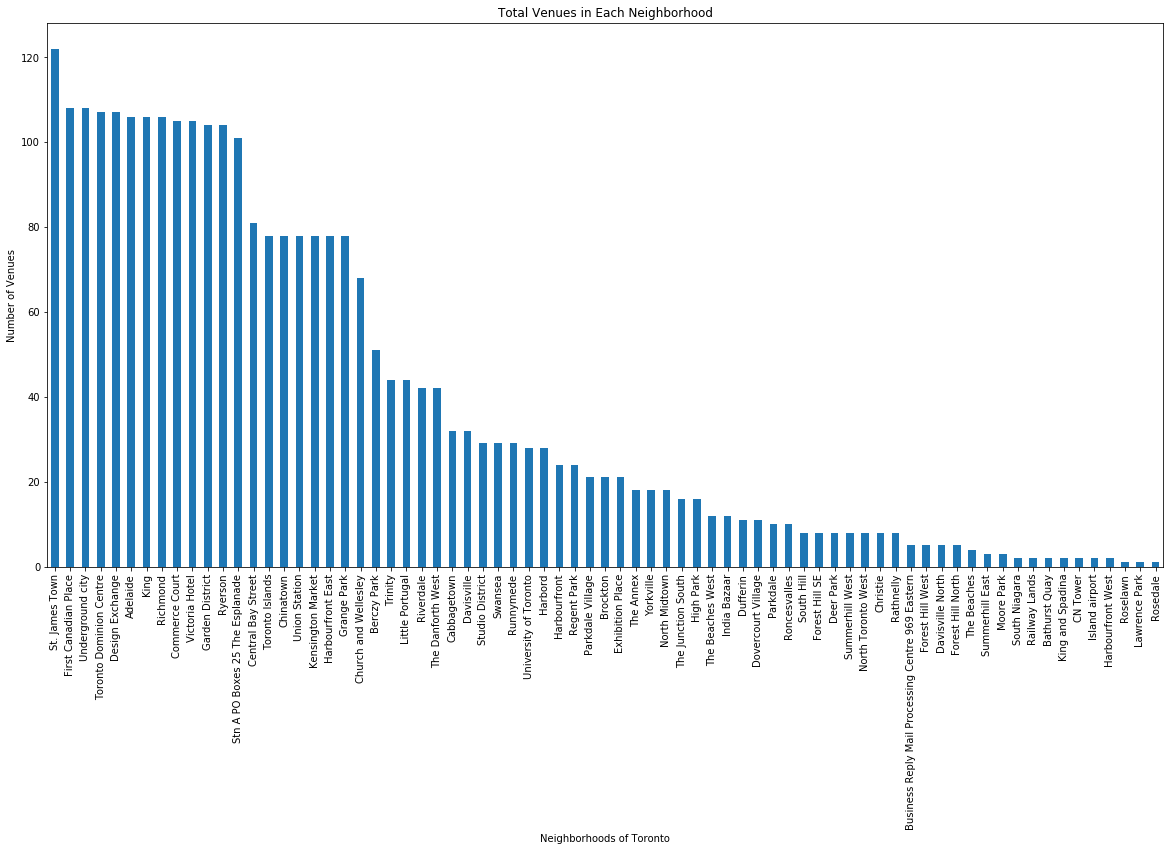

In [5]:
# Visualize the total venues in each neighborhood.
df_venues = df3.groupby(['Neighbourhood']).count().sort_values(by=['Venue'],ascending=False)
df_venues['Venue'].plot(kind='bar', figsize=(20,10))
plt.xlabel('Neighborhoods of Toronto')
plt.ylabel('Number of Venues')
plt.title('Total Venues in Each Neighborhood')
plt.show()

In [8]:
# Review the number of each category in all neighborhoods.
df_category = df3.groupby(['Category Rate']).count()
df_category['Venue']

Category Rate
1     105
2     584
3     723
4    1333
5      57
Name: Venue, dtype: int64

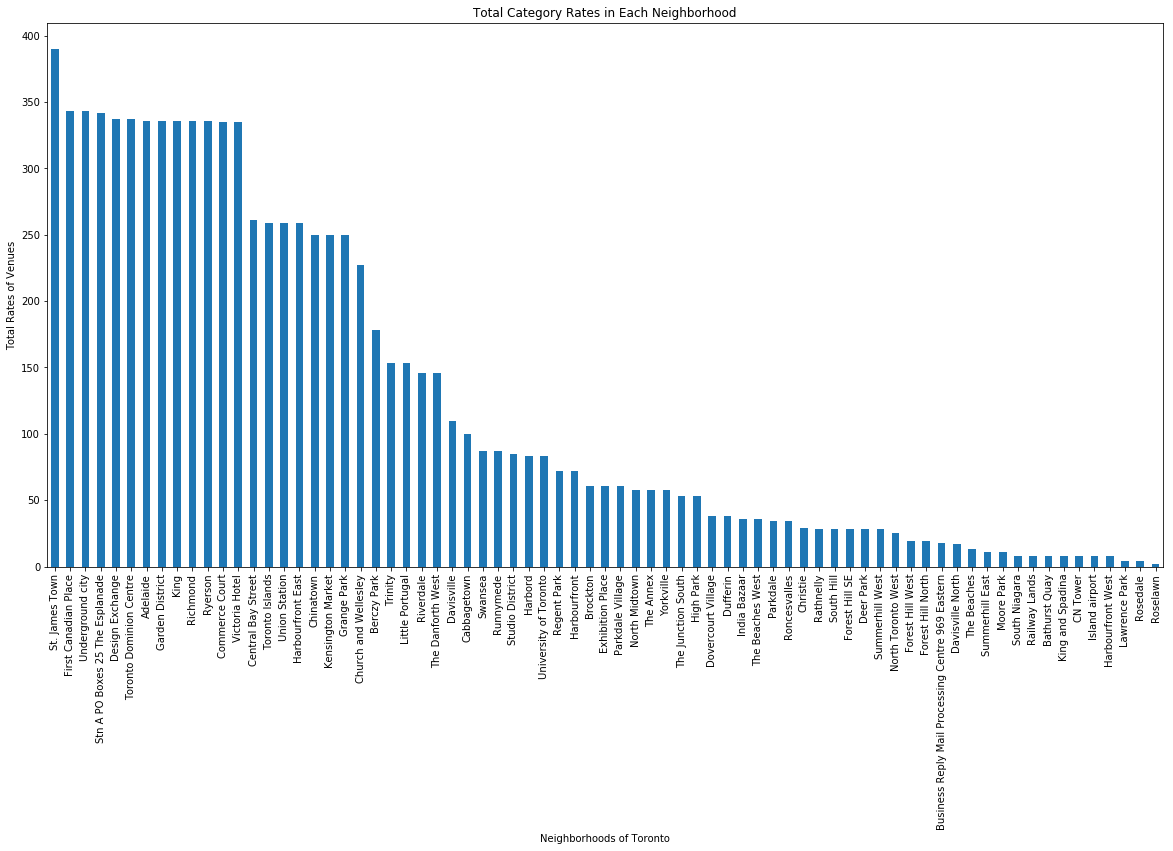

In [9]:
# Calculate the sum of rates in each neighborhood.
df_rates = df3.groupby(['Neighbourhood']).sum().sort_values(by=['Category Rate'],ascending=False)
df_rates['Category Rate'].plot(kind='bar', figsize=(20,10))
plt.xlabel('Neighborhoods of Toronto')
plt.ylabel('Total Rates of Venues')
plt.title('Total Category Rates in Each Neighborhood')
plt.show()

In [10]:
df_venues['Venue'].head(20)

Neighbourhood
St. James Town                     122
First Canadian Place               108
Underground city                   108
Toronto Dominion Centre            107
Design Exchange                    107
Adelaide                           106
King                               106
Richmond                           106
Commerce Court                     105
Victoria Hotel                     105
Garden District                    104
Ryerson                            104
Stn A PO Boxes 25 The Esplanade    101
Central Bay Street                  81
Toronto Islands                     78
Chinatown                           78
Union Station                       78
Kensington Market                   78
Harbourfront East                   78
Grange Park                         78
Name: Venue, dtype: int64

In [11]:
df_rates['Category Rate'].head(20)

Neighbourhood
St. James Town                     390
First Canadian Place               343
Underground city                   343
Stn A PO Boxes 25 The Esplanade    342
Design Exchange                    337
Toronto Dominion Centre            337
Adelaide                           336
Garden District                    336
King                               336
Richmond                           336
Ryerson                            336
Commerce Court                     335
Victoria Hotel                     335
Central Bay Street                 261
Toronto Islands                    259
Union Station                      259
Harbourfront East                  259
Chinatown                          250
Kensington Market                  250
Grange Park                        250
Name: Category Rate, dtype: int64

In [14]:
# Clean dataframe of neighborhoods with only including category rates.
df_nb = df3[['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude']].drop_duplicates(subset=['Neighbourhood'])
df3a = df_nb.merge(df_venues['Venue'], on='Neighbourhood')
df3a = df3a.merge(df_rates['Category Rate'], on='Neighbourhood').sort_values(by='Category Rate',ascending=False)
df3a.columns = ['Neighbourhood','Latitude','Longitude','Venue_Number', 'Category_Rate']
df3a.head(20)

,Neighbourhood,Latitude,Longitude,Venue_Number,Category_Rate
2,St. James Town,43.651494,-79.375418,122,390
36,First Canadian Place,43.648429,-79.382280,108,343
37,Underground city,43.648429,-79.382280,108,343
34,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,101,342
17,Toronto Dominion Centre,43.647177,-79.381576,107,337
16,Design Exchange,43.647177,-79.381576,107,337
8,Richmond,43.650571,-79.384568,106,336
1,Garden District,43.657162,-79.378937,104,336
0,Ryerson,43.657162,-79.378937,104,336
7,King,43.650571,-79.384568,106,336


In [15]:
# Divide the neighborhoods into 4 levels based on the Category Rate.
def lev(df3a):
  if df3a['Category_Rate'] >= 300:
    return '0'
  elif 200 <= df3a['Category_Rate'] < 300:
    return 1
  elif 100 <= df3a['Category_Rate'] < 200:
    return 2
  else:
    return 3
df3a['Level'] = df3a.apply(lev, axis=1).astype(int)

In [48]:
# Examine the clustering by reviewing a mannual classification
map_toronto = folium.Map(location=[43.65,-79.38], zoom_start=12)
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lng, nbh, level in zip(df3a['Latitude'], df3a['Longitude'], df3a['Neighbourhood'], df3a['Level']):
    label = folium.Popup(str(nbh) + ': Level' + str(level), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[level],
        fill=True,
        fill_color=rainbow[level],
        fill_opacity=0.7).add_to(map_toronto)  
map_toronto

# 4. Clustering of Neighborhoods

In [34]:
# Recall the dataframe from Section 2.
df4 = pd.read_csv('initialdf2.csv')
def lev(df4):
  if df4['Category Rate'] == 5:
    return 'I'
  elif df4['Category Rate'] == 4:
    return 'II'
  elif df4['Category Rate'] == 3:
    return 'III'
  elif df4['Category Rate'] == 2:
    return 'IV'
  else:
    return 'V'
df4['Level'] = df4.apply(lev, axis=1)

## 4.1 Analyze the Neighborhoods

In [35]:
# one hot encoding
toronto_onehot = pd.get_dummies(df4[['Level']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = df4['Neighbourhood'] 
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

In [36]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,I,II,III,IV,V
0,Adelaide,0.009434,0.433962,0.311321,0.207547,0.037736
1,Bathurst Quay,0.000000,1.000000,0.000000,0.000000,0.000000
2,Berczy Park,0.039216,0.568627,0.254902,0.117647,0.019608
3,Brockton,0.047619,0.285714,0.238095,0.380952,0.047619
4,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.600000,0.400000,0.000000,0.000000


In [37]:
# Write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
# Create a new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 5
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']
for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)
neighbourhoods_venues_sorted.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adelaide,II,III,IV,V,I
1,Bathurst Quay,II,V,IV,III,I
2,Berczy Park,II,III,IV,I,V
3,Brockton,IV,II,III,V,I
4,Business Reply Mail Processing Centre 969 Eastern,II,III,V,IV,I
5,CN Tower,II,V,IV,III,I
6,Cabbagetown,II,IV,III,V,I
7,Central Bay Street,II,IV,III,V,I
8,Chinatown,II,IV,III,I,V
9,Christie,II,IV,I,III,V


In [39]:
# set number of clusters
kclusters = 5
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 1, 2, 1, 0, 2, 1, 2, 2])

In [40]:
# Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = df1
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

In [41]:
# Visualize the clusters
map_clusters = folium.Map(location=[43.65, -79.37], zoom_start=12)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)      
map_clusters

## 4.2 Examine the clusters

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
111,Lawrence Park,0,II,V,IV,III,I
121,Forest Hill North,0,II,III,V,IV,I
122,Forest Hill West,0,II,III,V,IV,I
163,CN Tower,0,II,V,IV,III,I
164,Bathurst Quay,0,II,V,IV,III,I
165,Island airport,0,II,V,IV,III,I
166,Harbourfront West,0,II,V,IV,III,I
167,King and Spadina,0,II,V,IV,III,I
168,Railway Lands,0,II,V,IV,III,I
169,South Niagara,0,II,V,IV,III,I


In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,Ryerson,1,II,III,IV,V,I
13,Garden District,1,II,III,IV,V,I
26,St. James Town,1,II,III,IV,V,I
36,Berczy Park,1,II,III,IV,I,V
40,Central Bay Street,1,II,IV,III,V,I
48,Adelaide,1,II,III,IV,V,I
49,King,1,II,III,IV,V,I
50,Richmond,1,II,III,IV,V,I
60,Harbourfront East,1,II,III,IV,V,I
61,Toronto Islands,1,II,III,IV,V,I


In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Harbourfront,2,II,IV,III,V,I
3,Regent Park,2,II,IV,III,V,I
41,Christie,2,II,IV,I,III,V
51,Dovercourt Village,2,II,IV,III,I,V
52,Dufferin,2,II,IV,III,I,V
75,Brockton,2,IV,II,III,V,I
76,Exhibition Place,2,IV,II,III,V,I
77,Parkdale Village,2,IV,II,III,V,I
98,Studio District,2,II,IV,III,V,I
129,North Toronto West,2,II,IV,III,V,I


In [45]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
112,Roselawn,3,IV,V,III,II,I


# 5. Recommend the Neighborhood Candidates

In [46]:
# Select the neighborhoods from the above clusters where Level I was in 3rd and 4th Venues.
d= {'Neighbourhood': ['Berczy Park', 'The Danforth West', 'Riverdale', 'Parkdale','Roncesvalles', 'Christie', 'Dovercourt Village', 'Dufferin','Chinatown', 'Grange Park', 'Kensington Market']}
df5a = pd.DataFrame(data=d)
df5a = df5a.merge(df3a, on='Neighbourhood')
df5a

,Neighbourhood,Latitude,Longitude,Venue_Number,Category_Rate,Level
0,Berczy Park,43.644771,-79.373306,51,178,2
1,The Danforth West,43.679557,-79.352188,42,146,2
2,Riverdale,43.679557,-79.352188,42,146,2
3,Parkdale,43.648960,-79.456325,10,34,3
4,Roncesvalles,43.648960,-79.456325,10,34,3
5,Christie,43.669542,-79.422564,8,29,3
6,Dovercourt Village,43.669005,-79.442259,11,38,3
7,Dufferin,43.669005,-79.442259,11,38,3
8,Chinatown,43.653206,-79.400049,78,250,1
9,Grange Park,43.653206,-79.400049,78,250,1


In [47]:
# Examine how many supermarkets and groceries in each neighborhood.
df5b = df3.loc[df3['Category Rate']==5]
df5b['Neighbourhood'].value_counts()

Grange Park                        5
Kensington Market                  5
Chinatown                          5
Central Bay Street                 2
Berczy Park                        2
Stn A PO Boxes 25 The Esplanade    2
Christie                           2
Dovercourt Village                 2
St. James Town                     2
Dufferin                           2
Rathnelly                          1
Adelaide                           1
King                               1
Forest Hill SE                     1
Toronto Dominion Centre            1
Riverdale                          1
The Annex                          1
Garden District                    1
Parkdale Village                   1
Parkdale                           1
Exhibition Place                   1
Ryerson                            1
Cabbagetown                        1
North Midtown                      1
Harbourfront East                  1
Design Exchange                    1
Underground city                   1
D

### Summary
We can see the top 3 neighborhoods from both dataframes are the same. Since those neighborhoods ['Chinatown', 'Grange Park', 'Kensington Market'] are adjacent. That area is recommended to open the distribution warehouse.